This notebook was made to check the mixing region of jetty bathymetry with ferry data, to investigate if the modelled result makes sense.

In [1]:
import salinity
import datetime
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import matplotlib.gridspec as gridspec
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
%matplotlib inline

In [2]:
paths = {'all_reduced': '/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/',
        'jetty': '/data/jieliu/MEOPAR/river-treatment/oct8_10jetty1e0605/'}
grid10 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea10.nc')

In [3]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st=3

In [4]:
def salinity_plot_test(run_date, saline, run_lower, run_upper, path_ssh,t):
    """This function was made to plot ferry 1.5m with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_allredu, value_mean_4rd_allredu, \
    value_mean_aveallredu, value_mean_ave4allredu,\
    salinity11, salinity1_2_4, date_str = salinity.salinity_fxn\
    (saline, run_date, paths['all_reduced'],run_lower,run_upper)
    
    lon_model, lat_model, lon1_model, lat1_model,\
    value_mean_3rd_jetty, value_mean_4rd_jetty, \
    value_mean_avejetty, value_mean_ave4jetty,\
    salinity11, salinity1_2_4, date_str = salinity.salinity_fxn\
    (saline, run_date, paths['jetty'],run_lower,run_upper)

    fig = plt.figure(figsize=(15,12))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
    gs.update(wspace=0.17, hspace=0.3)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    axx = [ax0, ax1]
    ## 1.5m salinity comparison
    model_3rd_allredu=ax0.plot(lon_model,value_mean_3rd_allredu,'Indigo',\
                            linewidth=2, marker='*', label="all_redu" )
    model_3rd_allredu=ax0.plot(lon_model,value_mean_3rd_jetty,'Olive',\
                            linewidth=2, marker = 'o',label="jetty" )
    observation_salinity=ax0.plot(lon1_model,salinity1_2_4,'DarkGreen', \
                            linewidth=2, marker = '^',label="Observed")
    if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 :
        ax0.set_title('1.5m salinity at '+ run_lower.replace(hour = run_lower.hour+2,minute = 30)\
                      .strftime('%d-%b-%Y %H:%M'), fontsize = 16)
    else:
        ax0.set_title('1.5m salinity at '+ run_lower.replace(minute = 30).\
                      strftime('%d-%b-%Y %H:%M'), fontsize = 16)
    ax0.legend(loc = 'best',fontsize = 16)
    ax0.set_ylim(0, 30)
    ax0.set_ylabel('Practical Salinity', fontsize = 16)
    for ax in axx:
        ax.set_xlim(-124, -123)
        ax.set_xlabel('Longitude', fontsize = 16)
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
    
    base = '/data/jieliu/MEOPAR/river-treatment/'
    run = 'oct8_10jetty1e0605'
    grid_T = nc.Dataset(base+run+'/SalishSea_1h_20141008_20141010_grid_T.nc','r')
    if run_date.day==9:
        t_m = t+ 24
    if run_date.day ==10:
        t_m =t+24*2
    if run_date.day==8:
        t_m =t
    S_m = grid_T.variables['vosaline'][t_m, 1, jst:jen,ist:ien]
    lon = grid_T.variables['nav_lon'][jst:jen,ist:ien]
    lat = grid_T.variables['nav_lat'][jst:jen,ist:ien]
    cm = plt.cm.get_cmap('spectral',12)
    mesh=ax.pcolormesh(lon,lat,S_m,vmin =10,vmax = 30,cmap=cm)        
    viz_tools.plot_land_mask(ax,grid10,coords='map',xslice=x,yslice=y,color='burlywood')

    ax1.set_ylim([48.9,49.4])
    ax1.set_ylabel('Latitude', fontsize = 16)
    cbar = plt.colorbar(mesh, ax=ax1)
    cbar.set_label('Practical Salinity', fontsize = 16)

    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20) 
    ax1.set_title(run_date.replace(hour =t ,minute = 30).strftime('%d-%b-%Y %H:%M')+\
        ' 1.5m salinity distribution', fontsize = 16)  
    ## add ferry route
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Duke']
    for stn in stations:
        ax1.plot(salinity.ferry_stations[stn]['lon'], salinity.ferry_stations[stn]['lat'], marker='D', \
                    color='SpringGreen',markersize=20, markeredgewidth=2)
    ax1.annotate ('Tsawwassen',(salinity.ferry_stations['Tsawwassen']['lon']-0.07 ,\
    salinity.ferry_stations['Tsawwassen']['lat'] + 0.02), fontsize=15, color='black', bbox=bbox_args )
    ax1.annotate ('Duke Point',(salinity.ferry_stations['Duke']['lon'] -0.11 ,\
    salinity.ferry_stations['Duke']['lat']-0.05 ),fontsize=15, color='black', bbox=bbox_args )
    ax1.plot(lon_model,lat_model,'k', linewidth = 2)
    ## add ssh plot
    ssh,tt, hour = salinity.get_ssh_in_model(run_date, path_ssh,t)
    ax2.plot(tt[:],ssh[:, 466,329],'-k', linewidth = 2.5)
    ax2.plot(tt[t],ssh[t, 466,329], color = 'Maroon',marker='*', markersize = 16)
       
    ax2.set_title('Modelled water level at Point Atkinson on '\
                                       + tt[t].strftime('%d-%b-%Y %H:%M'), fontsize=16)
    ax2.set_xlabel('time', fontsize=16)
    ax2.set_ylabel('Water level (m)')
    plt.setp(ax2.get_xticklabels(), fontsize=16)
    plt.setp(ax2.get_yticklabels(), fontsize=16)
    return fig 

# Oct8

In [5]:
run_date = datetime.datetime(2014,10,8)
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141007.mat')

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


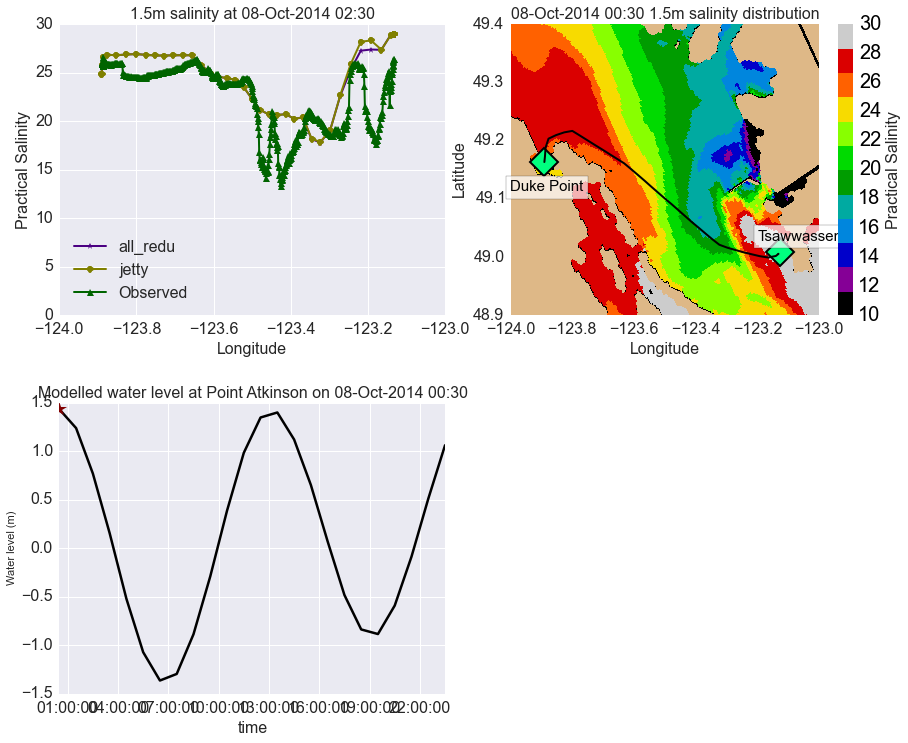

In [6]:
run_lower = run_date.replace(hour = 0, minute = 45)
run_upper = run_date.replace(hour = 3, minute =15)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 0)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


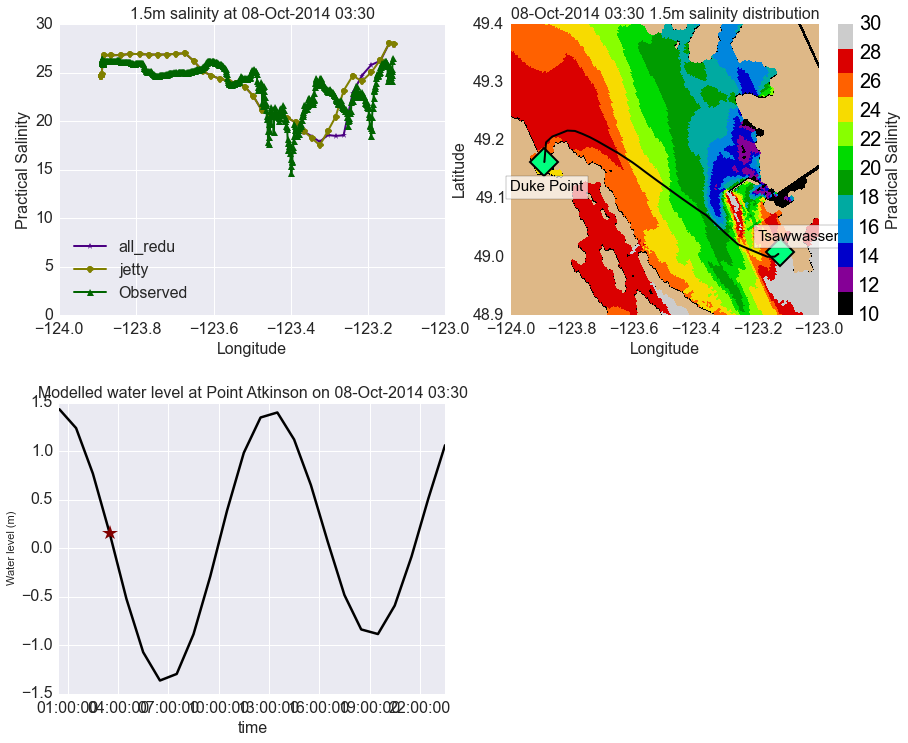

In [7]:
run_lower = run_date.replace(hour = 3, minute = 15)
run_upper = run_date.replace(hour = 5, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 3)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


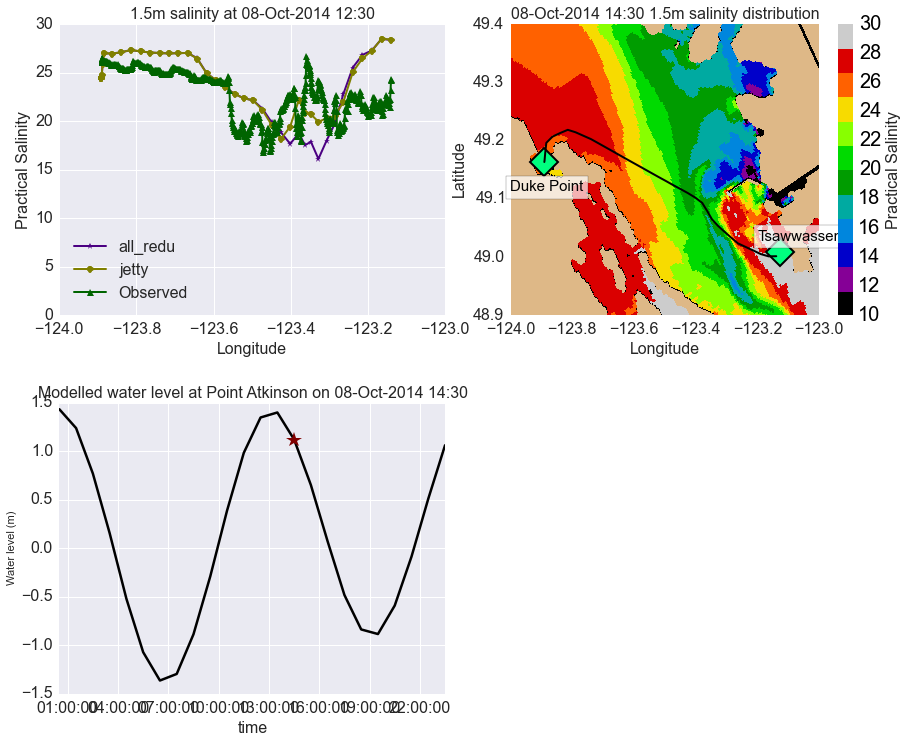

In [8]:
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141008.mat')
run_lower = run_date.replace(hour = 12, minute = 22)
run_upper = run_date.replace(hour = 14, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 14)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


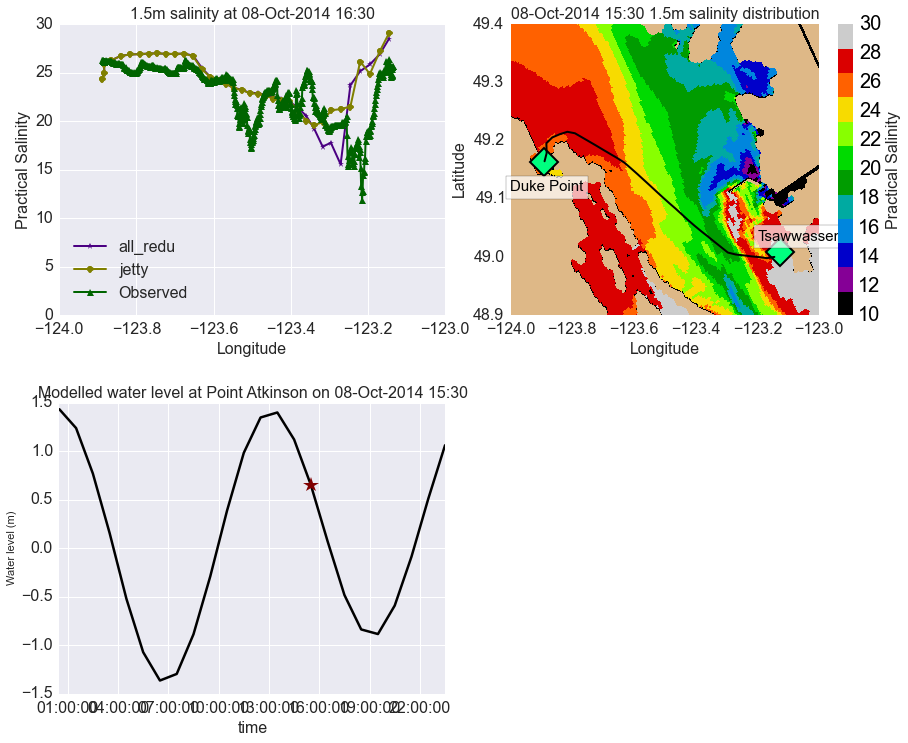

In [9]:
run_lower = run_date.replace(hour = 14, minute = 45)
run_upper = run_date.replace(hour = 16, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 15)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


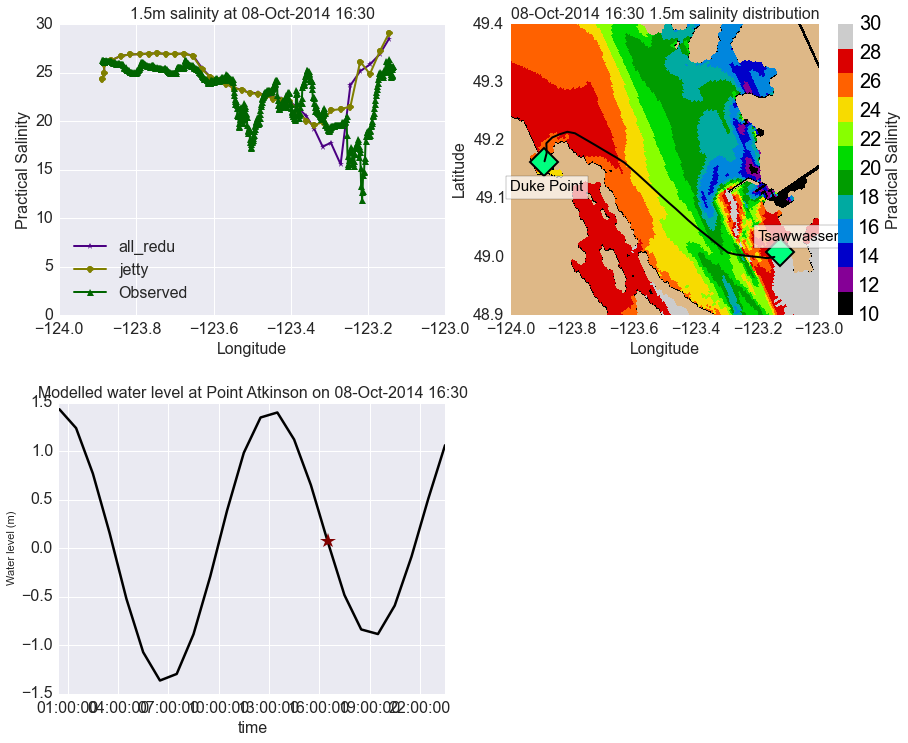

In [10]:
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 16)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


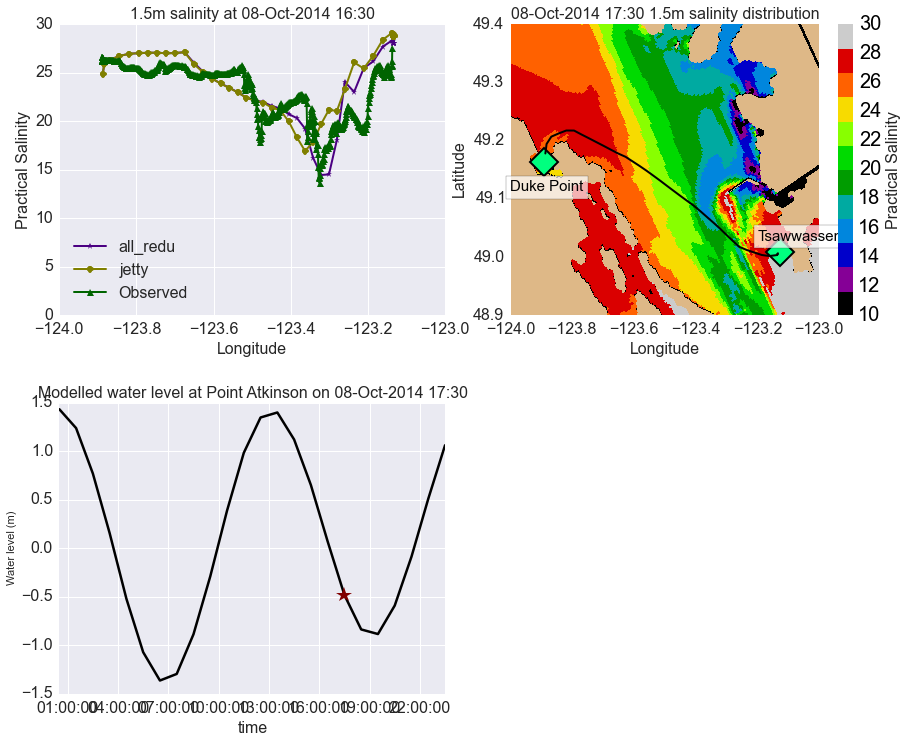

In [11]:
run_lower = run_date.replace(hour = 16, minute = 45)
run_upper = run_date.replace(hour = 19, minute =15)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 17)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


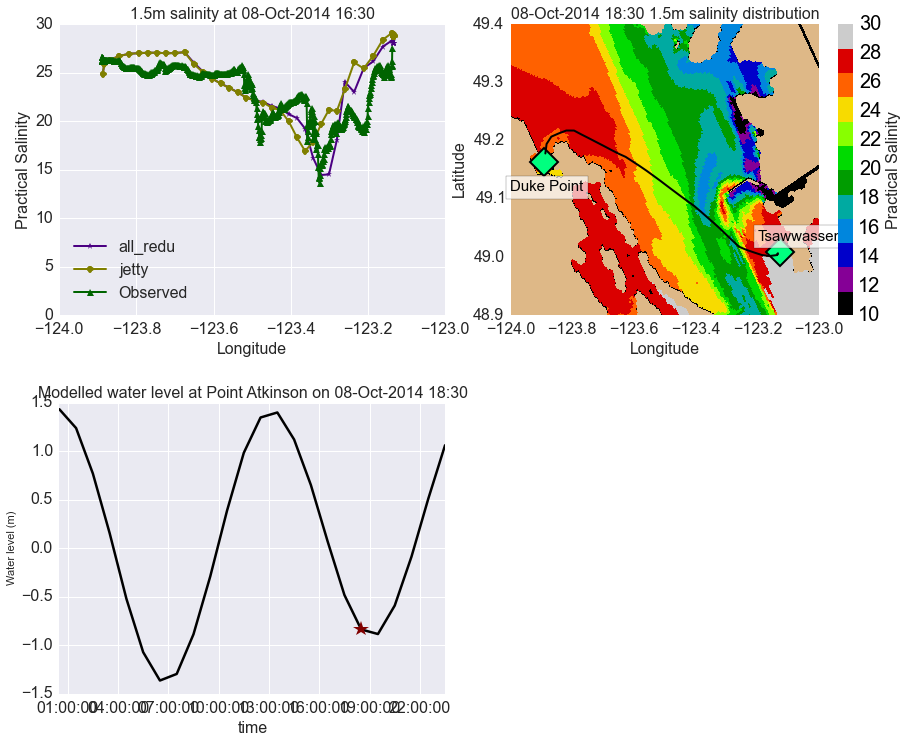

In [12]:
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 18)

# Oct9

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


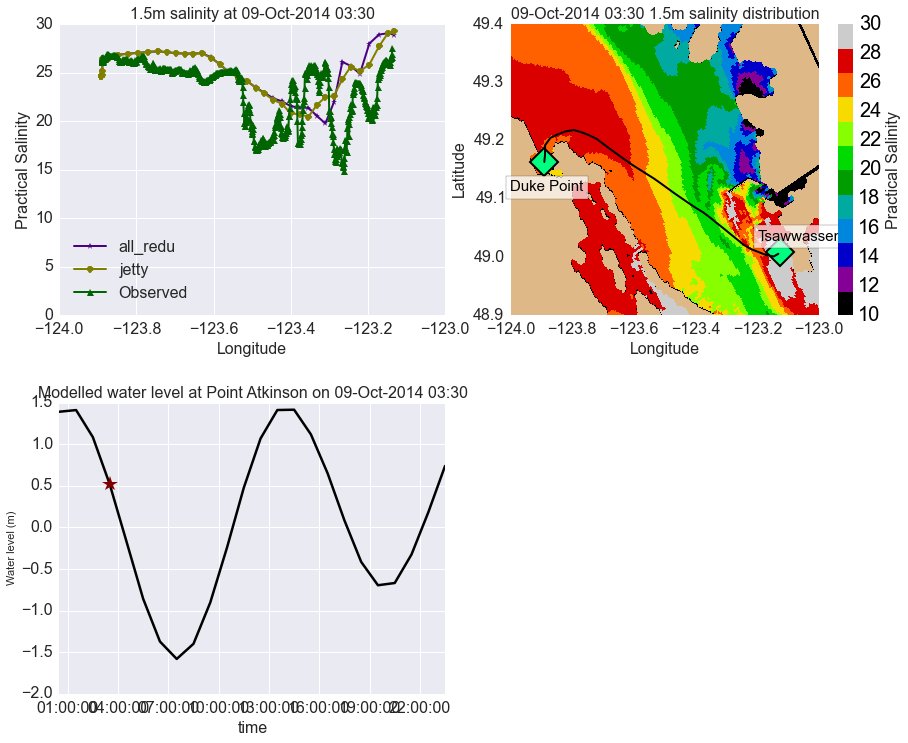

In [13]:
run_date = datetime.datetime(2014,10,9)
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141008.mat')
run_lower = run_date.replace(hour =3, minute = 15)
run_upper = run_date.replace(hour = 5, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 3)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


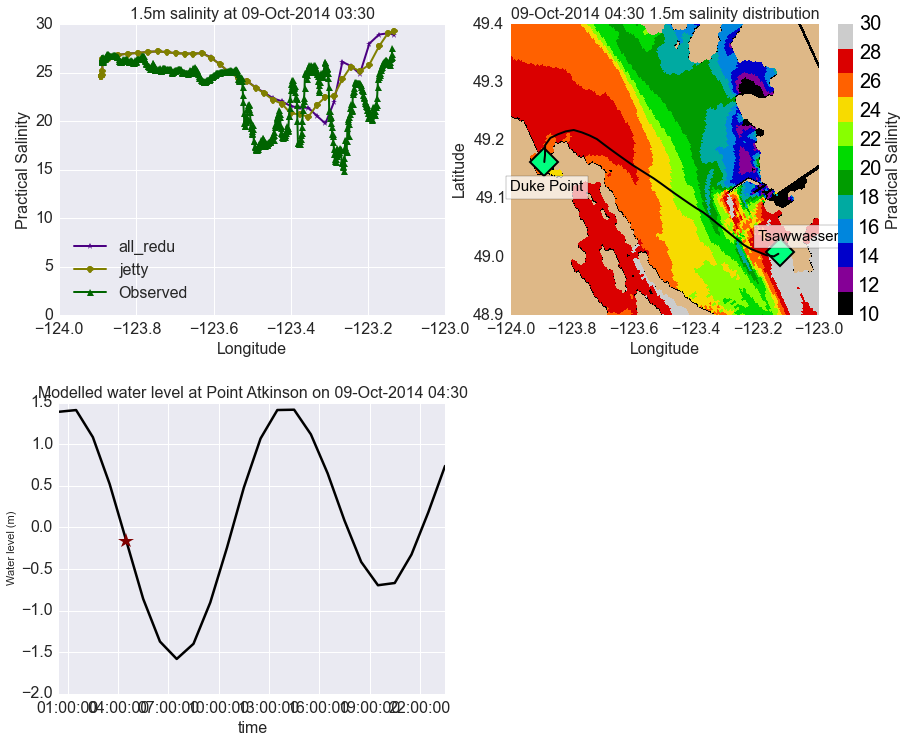

In [14]:
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 4)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


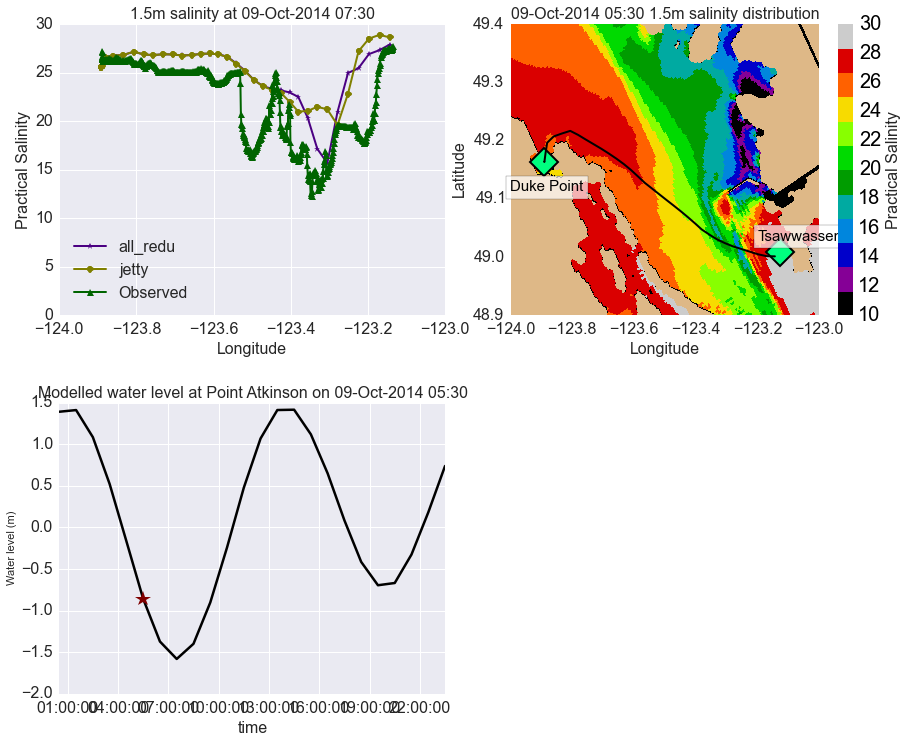

In [15]:
run_lower = run_date.replace(hour =5, minute = 15)
run_upper = run_date.replace(hour = 7, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 5)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


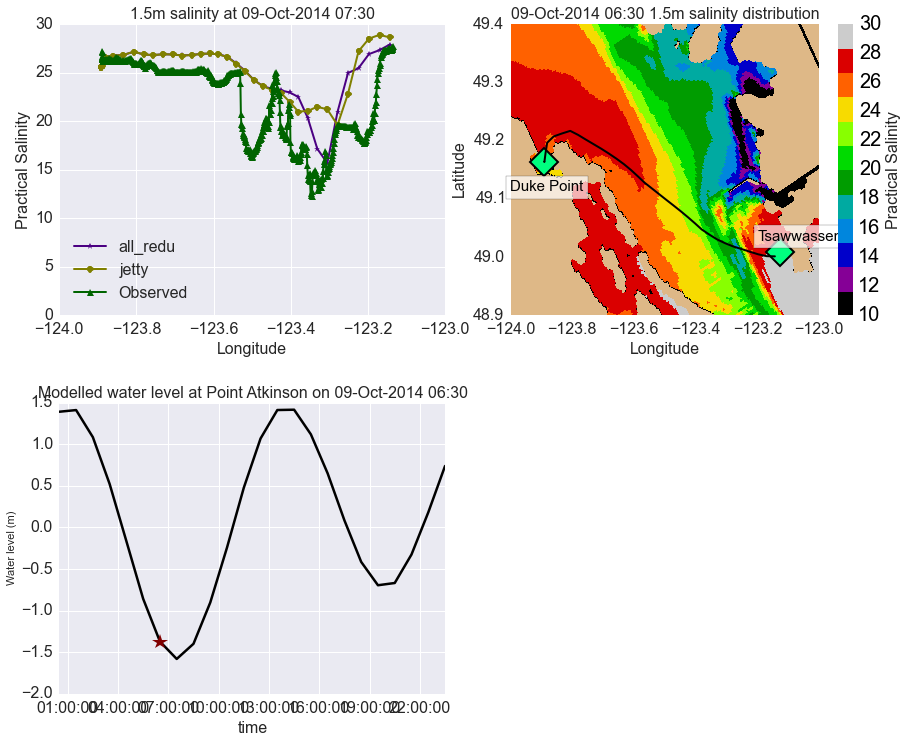

In [16]:
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 6)

# Oct10

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


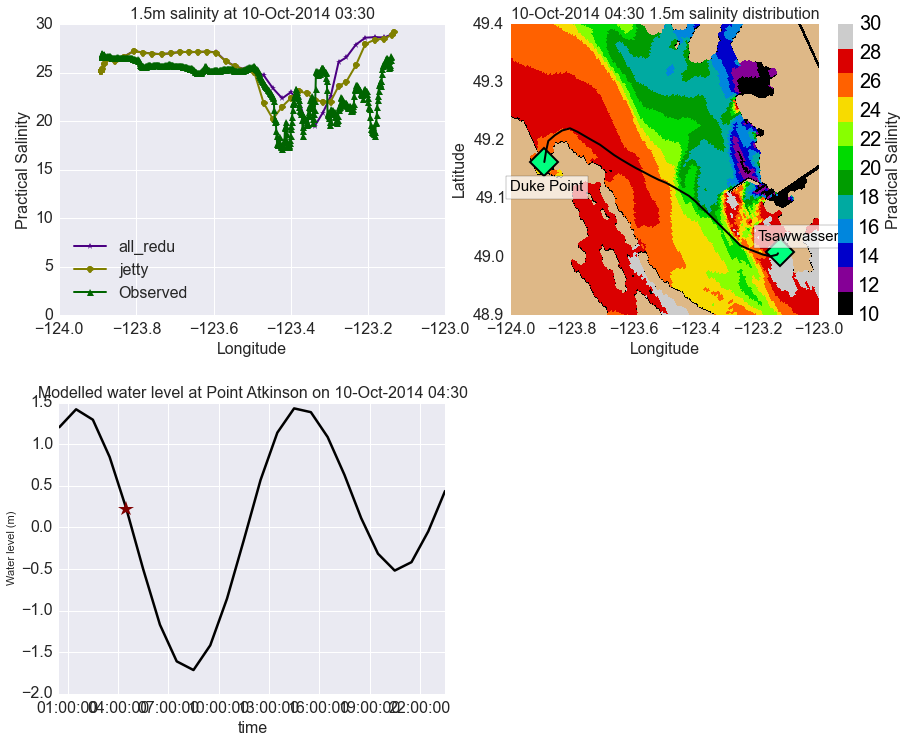

In [17]:
run_date = datetime.datetime(2014,10,10)
saline=sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE1920141009.mat')
run_lower = run_date.replace(hour =3, minute = 15)
run_upper = run_date.replace(hour = 5, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 4)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


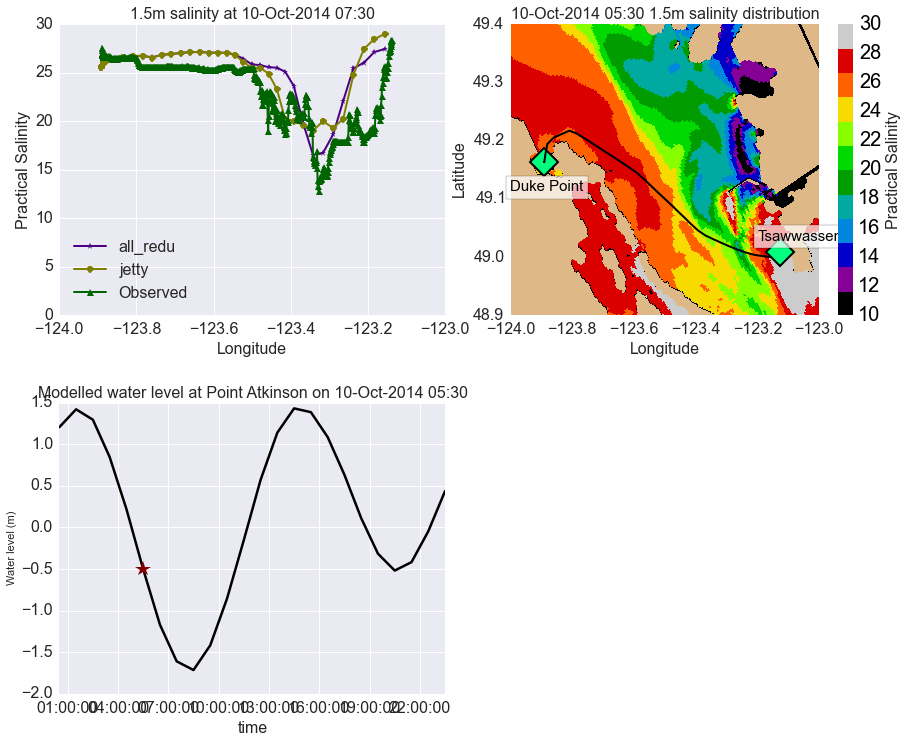

In [18]:
run_lower = run_date.replace(hour =5, minute = 15)
run_upper = run_date.replace(hour = 7, minute =45)
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 5)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


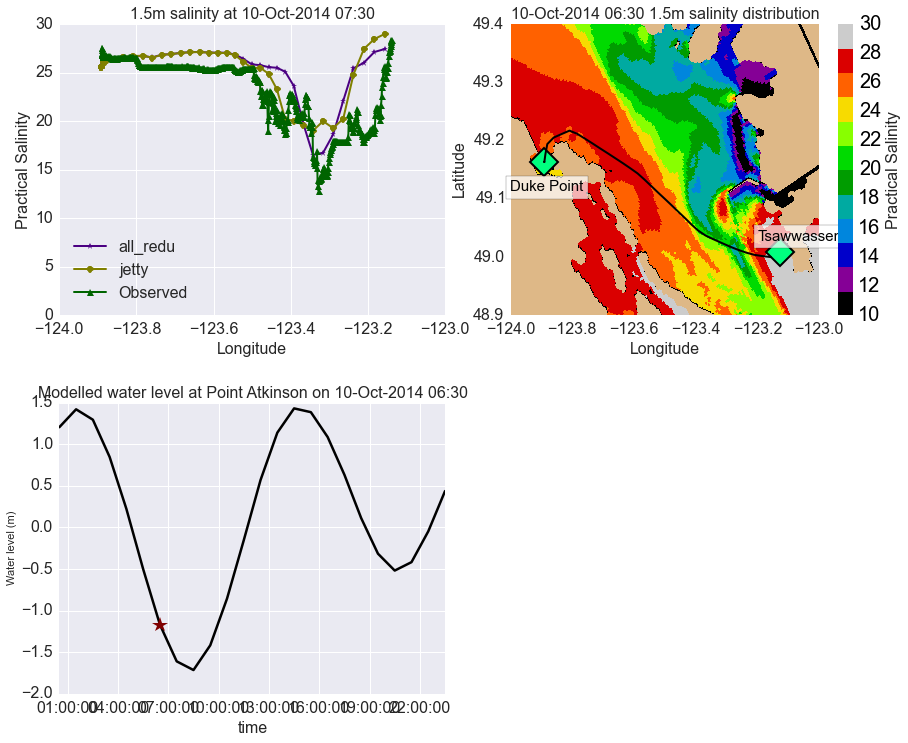

In [19]:
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 6)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


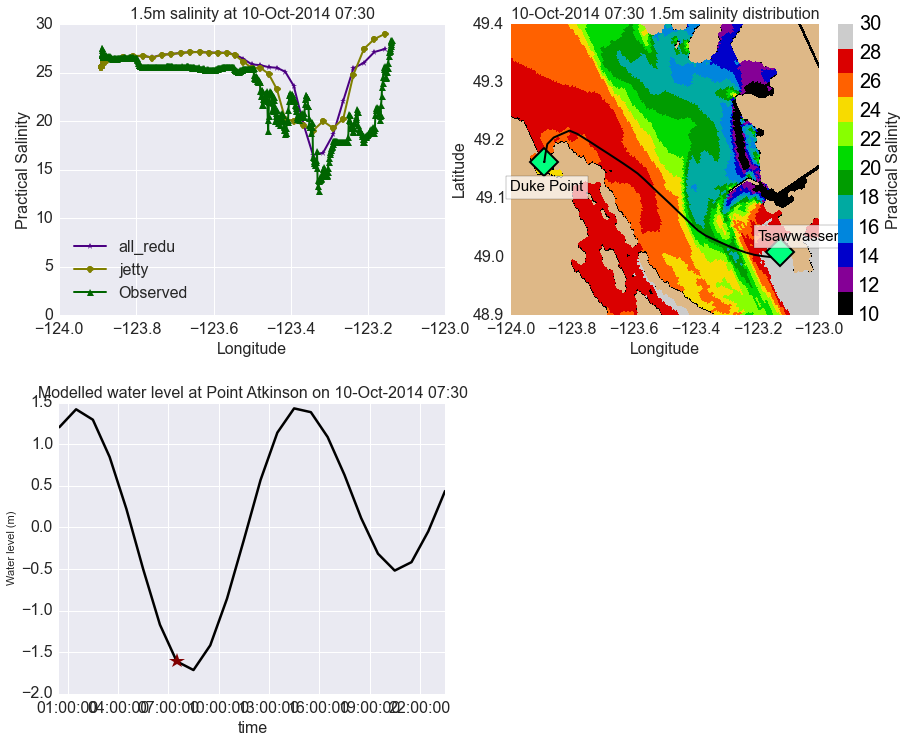

In [20]:
fig = salinity_plot_test(run_date,saline, run_lower,run_upper,paths['jetty'], 7)